In [1]:
from __future__ import print_function

import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import scipy.linalg as linalg

import os
import math

%matplotlib inline

### 获取转换矩阵
#### 内外参数

In [2]:
[roll, pitch, yaw] = [0.0, 9.200, -1.047]
height = 1.870
# 参数分别是旋转轴和旋转弧度值
def rotate_mat(axis, radian):
    rot_matrix = linalg.expm(np.cross(np.eye(3), axis / linalg.norm(axis) * radian))
    return rot_matrix

axis_x, axis_y, axis_z = [1,0,0], [0,1,0], [0, 0, 1]#分别是x,y和z轴,也可以自定义旋转轴
ExM = np.dot(rotate_mat(axis_x, pitch * math.pi/180),
             np.dot(rotate_mat(axis_y, yaw * math.pi/180) , rotate_mat(axis_z, roll * math.pi/180)))

ExM = np.append(ExM, [[0],[0],[0]], axis = 1)
# ExM = rot_matrix
print (ExM)


InM = np.array([[1197, 0, 525], [0, 1192, 389], [0, 0, 1]])


[[ 0.99983304  0.         -0.01827258  0.        ]
 [-0.00292144  0.98713627 -0.15985449  0.        ]
 [ 0.01803753  0.15988119  0.98697146  0.        ]]


#### 获取俯瞰图和原图的对应四个角点坐标

In [3]:
Pin = np.float32([[-5, height, 10, 1],
                  [5,  height, 10, 1],
                  [-5, height, 50, 1],
                  [5,  height, 50, 1]])

Pout =  np.dot(InM, np.dot(ExM, Pin.T))

Pout = Pout / Pout[2,:]
print (Pout)

in_points = np.float32([[0, 1024],[1024, 1024], [0, 0], [1024, 0]])
out_points = Pout[:2,:].T.astype(np.float32)
# out_points = out_points

ipm_map = cv2.getPerspectiveTransform(out_points, in_points)

[[-9.04408521e+01  1.08697928e+03  3.82183388e+02  6.23323466e+02]
 [ 4.19987974e+02  4.16048651e+02  2.41503253e+02  2.41338009e+02]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]]


In [176]:
# wrap_map = np.array([[-6.2585619983117446e-01, -2.7825934093871529e+00,8.2584509284977173e+02], 
#                      [-2.7341215332273849e-03, -4.2532322768005697e+00, 9.6413267099230768e+02],
#                      [ 1.9360772750623423e-11, -5.4438947183278385e-03, 1. ]])
# plt.imshow(wrap_map)
# print (wrap_map)

#### 投影变换

Text(0.5, 1.0, 'Warp_Image')

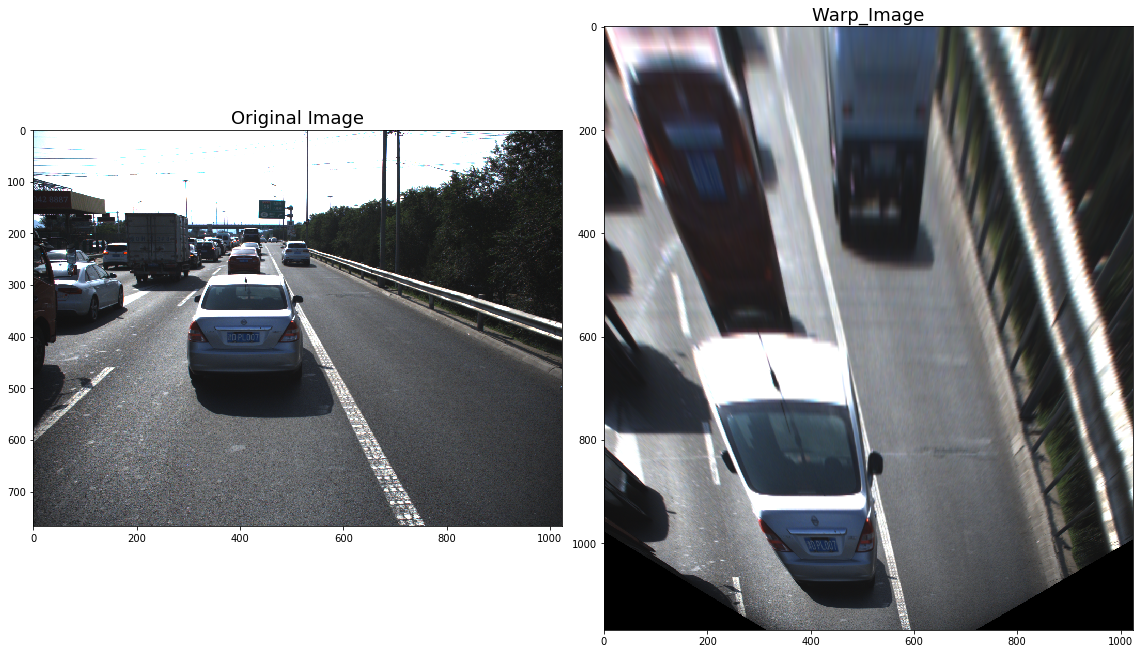

In [4]:
def perspective_transform(img, M):
    img_size = (img.shape[1], img.shape[0]+400)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
#     warped = cv2.resize(warped, (640,480))
    return warped

# img_in = cv2.imread('/media/andy/DATA1/08_Data/2018-08-16/image/2018-08-16_15-50-00_00001753.bmp')
# fig = plt.figure()
# plt.imshow(img_in)
# import os
# import time
# i = 0

path = '/media/andy/DATA1/08_Data/2018-08-16/image'
# image_list = path + '/image_filelist.txt'
image_list = os.listdir(path)

# for file in os.listdir(path):
#     i = i +1
#     img_in = cv2.imread(os.path.join(path, file))
#     wrap_img= perspective_transform(img_in, ipm_map)
# #     plt.imshow(wrap_img)
# #     time.sleep(0.2)
#     cv2.imshow('bird', wrap_img)
#     cv2.waitKey()
#     if i > 200:
#         break

image_name = os.path.join(path, image_list[300])

img_origin = cv2.imread(image_name)
img_origin = cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB)
img_warp = perspective_transform(img_origin, ipm_map)

f, axs = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()
axs[0].imshow(img_origin)
axs[0].set_title('Original Image', fontsize=18)
axs[1].imshow(img_warp, cmap='gray')
axs[1].set_title('Warp_Image', fontsize=18)

### Detection
#### Sobel 滤波器

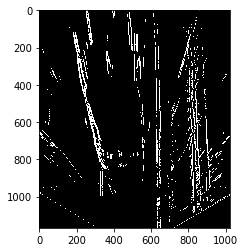

In [17]:
def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary

# fig = plt.figure(figsize=(1024,720))
img_sobel = abs_sobel_thresh(img_warp, thresh=(20, 255))
plt.imshow(img_sobel, cmap='gray')

In [ ]:


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

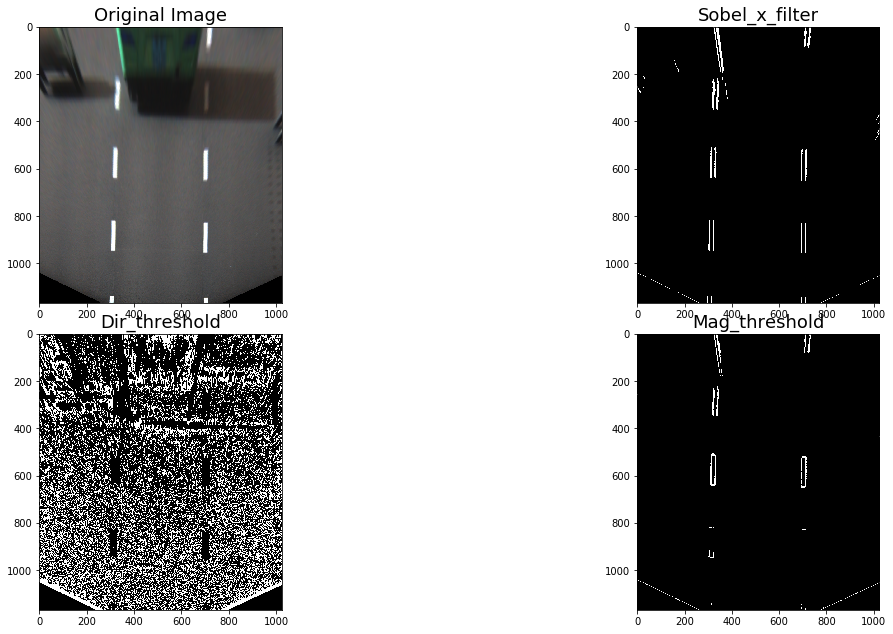

In [179]:
ksize = 9 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(wrap_img, orient='x', sobel_kernel=3, thresh=(20, 255))

mag_binary = mag_thresh(wrap_img, sobel_kernel=3, mag_thresh=(30, 100))
dir_binary = dir_threshold(wrap_img, sobel_kernel=15, thresh=(0.7, 1.3))

# Plot the result
f, axs = plt.subplots(2, 2, figsize=(16, 9))
f.tight_layout()
axs[0, 0].imshow(wrap_img)
axs[0, 0].set_title('Original Image', fontsize=18)
axs[0, 1].imshow(gradx, cmap='gray')
axs[0, 1].set_title('Sobel_x_filter', fontsize=18)
axs[1, 0].imshow(dir_binary, cmap='gray')
axs[1, 0].set_title('Dir_threshold', fontsize=18)
axs[1, 1].imshow(mag_binary, cmap='gray')
axs[1, 1].set_title('Mag_threshold', fontsize=18)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


#### 色彩阈值化

In [180]:
def r_select(img, thresh=(200, 255)):
    R = img[:,:,0]
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    return binary

def color_mask(hsv,low,high):
    # Return mask from HSV
    mask = cv2.inRange(hsv, low, high)
    return mask

def apply_color_mask(hsv,img,low,high):
    # Apply color mask to image
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img,img, mask= mask)
    return res

def apply_yellow_white_mask(img):
    image_HSV = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    yellow_hsv_low  = np.array([ 0,  100,  100])
    yellow_hsv_high = np.array([ 80, 255, 255])
    white_hsv_low  = np.array([ 0,   0,   160])
    white_hsv_high = np.array([ 255,  80, 255])
    mask_yellow = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
    mask_white = color_mask(image_HSV,white_hsv_low,white_hsv_high)
    mask_YW_image = cv2.bitwise_or(mask_yellow,mask_white)
    return mask_YW_image

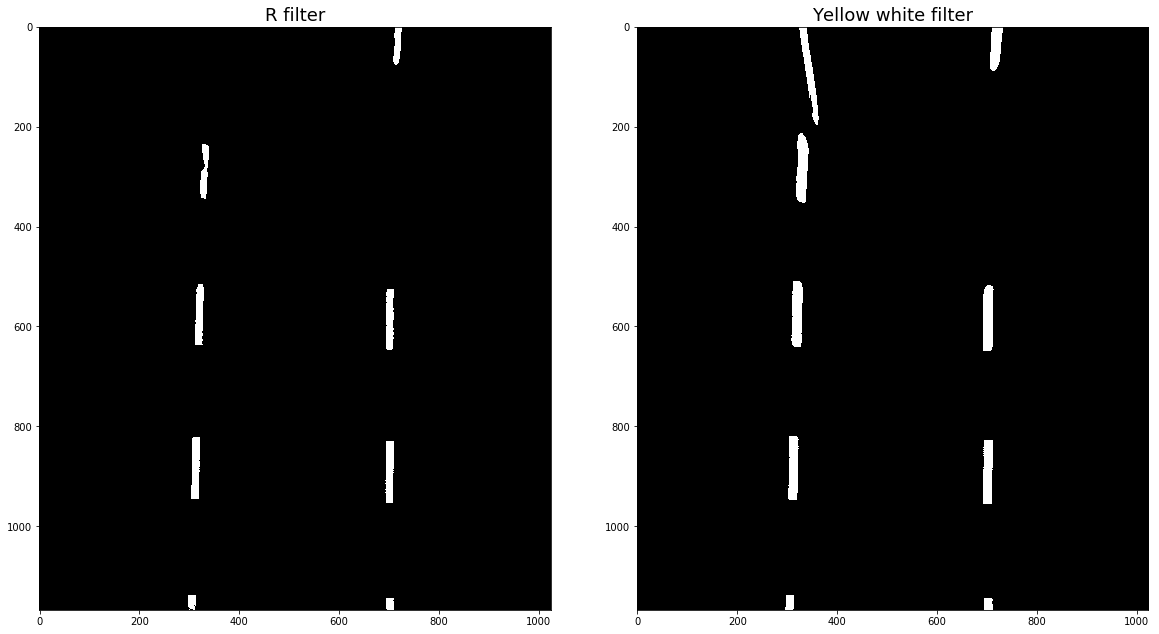

In [181]:
r_binary = r_select(wrap_img, thresh=(220, 255))
yw_binary = apply_yellow_white_mask(wrap_img)
# Plot the result
f, axs = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()
axs[0].imshow(r_binary, cmap='gray')
axs[0].set_title('R filter', fontsize=18)
axs[1].imshow(yw_binary, cmap='gray')
axs[1].set_title('Yellow white filter', fontsize=18)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

#### HLS 阈值化处理

In [182]:
def hls_select(img, channel='S', thresh=(90, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel == 'S':
        X = hls[:, :, 2]
    elif channel == 'H':
        X = hls[:, :, 0]
    elif channel == 'L':
        X = hls[:, :, 1]
    else:
        print('illegal channel !!!')
        return
    binary_output = np.zeros_like(X)
    binary_output[(X > thresh[0]) & (X <= thresh[1])] = 1
    return binary_output

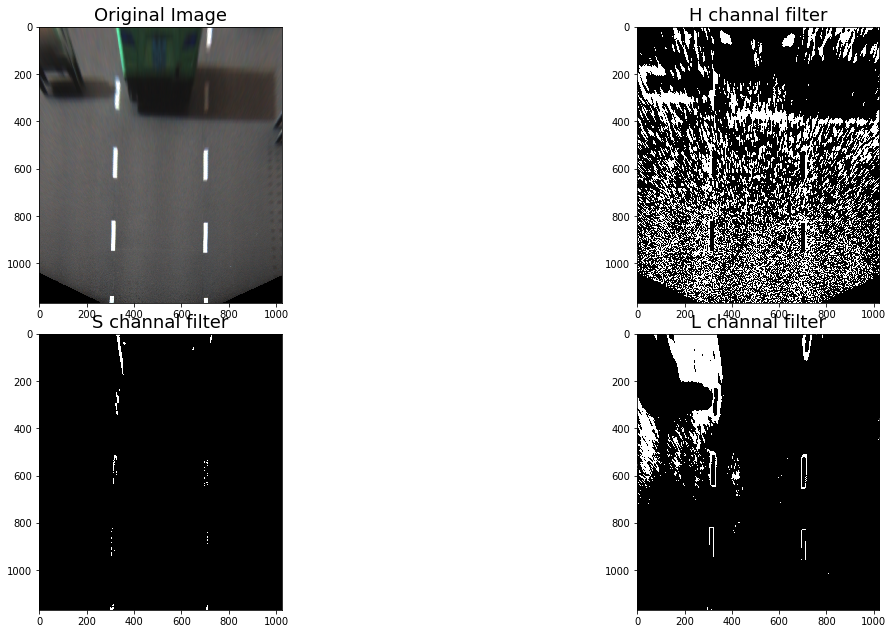

In [183]:
l_binary = hls_select(wrap_img, channel='L', thresh=(100, 200))
s_binary = hls_select(wrap_img, channel='S', thresh=(100, 255))
h_binary = hls_select(wrap_img, channel='H', thresh=(100, 255))
f, axs = plt.subplots(2, 2, figsize=(16, 9))
f.tight_layout()
axs[0, 0].imshow(wrap_img)
axs[0, 0].set_title('Original Image', fontsize=18)
axs[0, 1].imshow(h_binary, cmap='gray')
axs[0, 1].set_title('H channal filter', fontsize=18)
axs[1, 0].imshow(s_binary, cmap='gray')
axs[1, 0].set_title('S channal filter', fontsize=18)
axs[1, 1].imshow(l_binary, cmap='gray')
axs[1, 1].set_title('L channal filter', fontsize=18)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

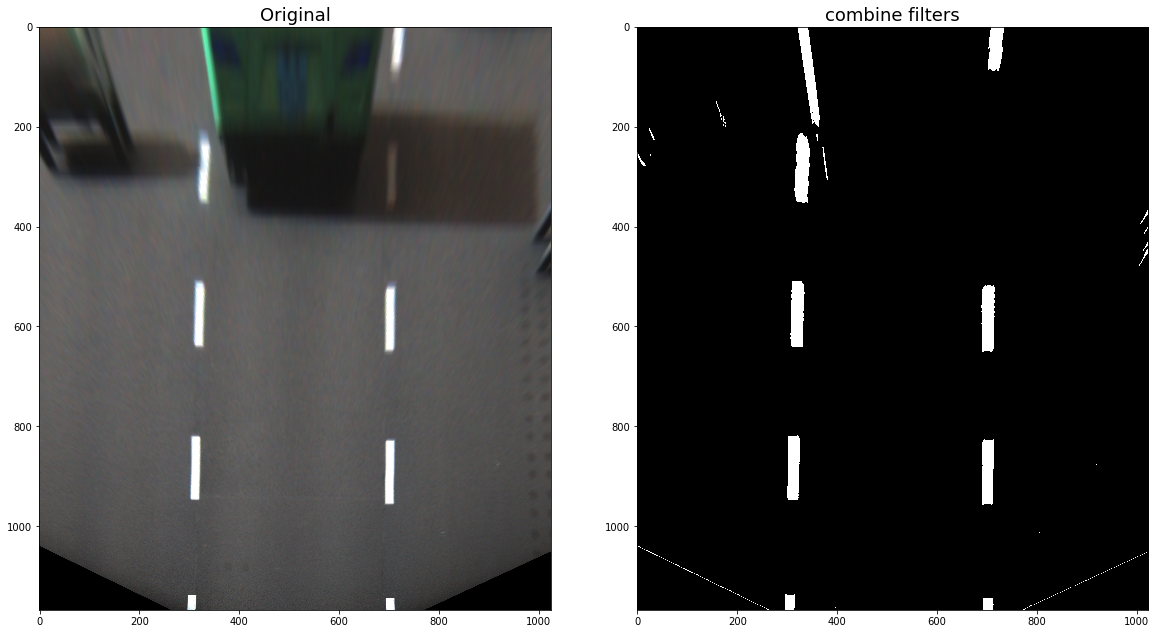

In [184]:
def combine_filters(img):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 255))
    l_binary = hls_select(img, channel='L', thresh=(100, 200))
    s_binary = hls_select(img, channel='S', thresh=(100, 255))
    yw_binary = apply_yellow_white_mask(wrap_img)
    yw_binary[(yw_binary !=0)] = 1
    combined_lsx = np.zeros_like(gradx)
    combined_lsx[((l_binary == 1) & (s_binary == 1) | (gradx == 1) | (yw_binary == 1))] = 1
    return combined_lsx

binary = combine_filters(wrap_img)
f, axs = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()
axs[0].imshow(wrap_img)
axs[0].set_title('Original', fontsize=18)
axs[1].imshow(binary, cmap='gray')
axs[1].set_title('combine filters', fontsize=18)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### 滑动窗口与多项式拟合
具体来说，为了确定哪些像素属于车道线，首先确定左右两条车道线的大致位置，这一步非常简单，只需要将图片中的像素沿y轴累加，找出图片中间点左右的峰值，即为车道线可能的区域，然后自底向上使用滑动窗口，计算窗口内的不为0的像素点，如果像素点的数量大于某个阈值，那么就以这些点的均值作为下一个滑动窗口的中心。
得到候选的像素以后，使用numpy中的 np.polyfit()方法来拟合这些点，我们使用一个二次多项式来拟合

In [185]:
def find_line_fit(img, nwindows=9, margin=100, minpix=50):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img)) * 255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    start_base = 100
    leftx_base = np.argmax(histogram[start_base:midpoint]) + start_base
    rightx_base = np.argmax(histogram[midpoint:-start_base]) + midpoint

    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # to plot
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, out_img

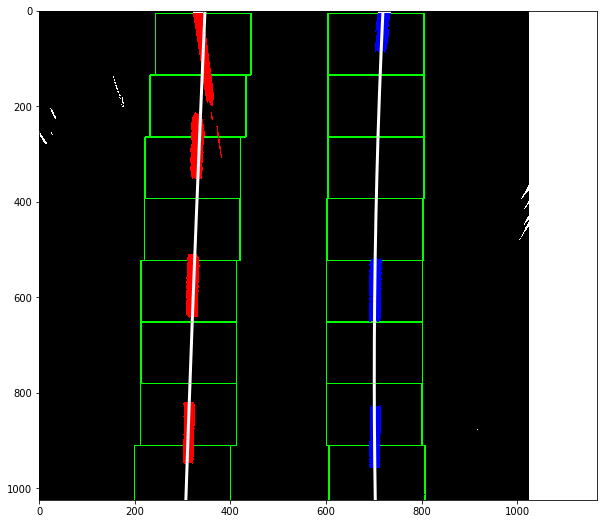

In [186]:
# Generate x and y values for plotting
def get_fit_xy(img, left_fit, right_fit):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx, ploty

left_fit, right_fit, out_img = find_line_fit(binary)
left_fitx, right_fitx, ploty = get_fit_xy(binary, left_fit, right_fit)

fig = plt.figure(figsize=(16, 9))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='white', linewidth=3.0)
plt.plot(right_fitx, ploty, color='white',  linewidth=3.0)
plt.xlim(0, out_img.shape[0])
plt.ylim(out_img.shape[1], 0)
plt.show()

In [187]:
out_img.shape[0]


1168

323.20145347537687 705.6122228391529 382.410769363776
(1168, 1024, 3)


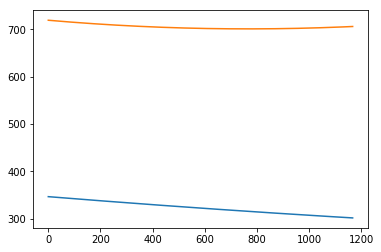

In [188]:
plt.plot(left_fitx)
plt.plot(right_fitx)
print(np.mean(left_fitx), np.mean(right_fitx), np.mean(right_fitx) -np.mean(left_fitx) )
print(out_img.shape)